# 3D MOT

### Setting up a 3D MOT with arbitrary beam directions

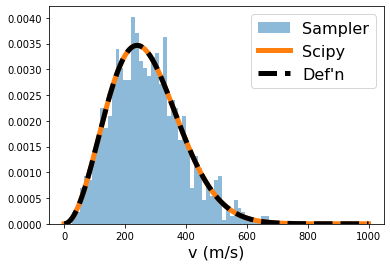

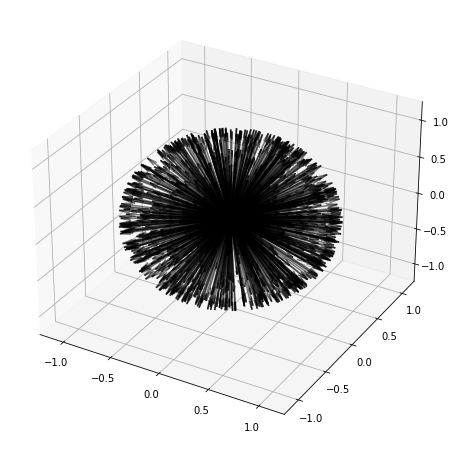

In [5]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import random
from scipy.interpolate import interpn
from scipy.spatial import cKDTree
import time
import nbimporter
%run MaxwellBoltzmann.ipynb

In [4]:
# Get the overlal detunings for the cooling beams.
def getDeltaPM(x, v, det, Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    return Delta_plus, Delta_minus

# Helper function for forceRadiative function.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

def forceRad(x0, v0, det, Bfieldcomp, s_adj):    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, Bfieldcomp)
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adj)
    return force

def getRandomX():
    return np.array([np.random.uniform(-x_len/2, x_len/2),np.random.uniform(-y_len/2, y_len/2), np.random.uniform(-z_len/2, z_len/2) ])

In [ ]:
# One step of 4th Order Runge-Kutte algorithm.
# Set interpolate to False if you want to do the computationally
# expensive task of evaluating B-field at exact particle positions.
def RK4_step(force, xn, yn, zn, vn, axis, quadcoil, dt, m=mass, interpolate=True):
        # Initialize parameters
        det = np.NaN
        #bgrad = np.NaN  # No longer needed due to coils.
        exponent = np.NaN
        s0 = np.NaN
        Bfieldcomp = np.NaN
        
        # Position variable
        pn = -10e9 # initialize outside of the axis-determination if blocks.
        
        if axis == 0: # x-axis.
            # Adjustment exponent for s0 -> s0e^{-2exponent}:
            exponent = (yn/short_cooling_waist)**2 + (zn/long_cooling_waist)**2
            # I/I_{sat}
            s0 = s0_cooling 
            # Detuning for x:
            det = det_x 
            # Set variable to edit in this RK4 step.
            pn = xn
        elif axis == 1: # y-axis.
            exponent = (xn/short_cooling_waist)**2 + (zn/long_cooling_waist)**2
            s0 = s0_cooling
            det = det_y
            pn = yn
        elif axis == 2: # z-axis.
            exponent = (xn/push_waist)**2 + (yn/push_waist)**2
            s0 = s0_push
            det = [det_push, det_counter]
            pn = zn
            
        # Make s_adj with the waist:
        s_adj = s0 * np.exp(-2*exponent)
        
        if interpolate:
            # Use B-field grid. If interpolate is on, then quadcoil = [tree, Bfields]
            # calculated from buildBfieldGrid() function
            tree = quadcoil[0]
            Bfields = quadcoil[1]
            point = [xn * 10**3, yn * 10**3, zn * 10**3] # Be sure to convert positions to mm.
            Bfieldcomp = 0.001 * queryLUT(point, tree, Bfields, axis) # convert to Tesla from mT
        else:
            # Get the B-field from the quadcoil. 
            # It comes from magpy in mT, so multiply by 1/1000.
            Bfieldcomp = 0.001 * magpy.getB(quadcoil, observers=(xn* 10**3, yn * 10**3, zn * 10**3))[axis]
        
        # Turn gravity on in the -y direction.
        g = 9.8 # m/s^2
        gravOn = 0 # Default is 0, meaning gravity shouldn't be in the force.
        if axis == 1: # y-axis:
            gravOn = 1
        
        # Make an RK4 STEP.
        K1 = force(pn, vn, det, Bfieldcomp, s_adj)/m  - gravOn*g
        L1 = vn
        
        K2 = force(pn + dt*L1/2, vn + dt*K1/2, det, Bfieldcomp, s_adj)/m - gravOn*g
        L2 = vn + dt*K1/2
        
        K3 = force(pn + dt*L2/2, vn + dt*K2/2, det, Bfieldcomp, s_adj)/m - gravOn*g
        L3 = vn + dt*K2/2
        
        K4 = force(pn + dt*L3, vn + dt*K3, det, Bfieldcomp, s_adj)/m - gravOn*g
        L4 = vn + dt*K3
        
        # Update xn and vn.
        # If z > z_len/2, then atom is in the tube,
        # then x,y beams should do nothing.
        if zn > z_len/2 and axis < 2: # x: axis = 0, y: axis = 1, z: axis = 3.
            pn = pn + vn*dt
            vn = vn
        else:
            pn = pn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
            vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        return pn, vn, K1*m # return force for logging

# One step of the simulation of a particle's trajectory.
# Requires the use of RK4_Step for each direction.
def step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt):
    # Unpack vec_x
    xn, yn, zn = vec_x
    # Unpack vec_v
    vxn, vyn, vzn = vec_v
    
    # Time-evolve
    # x-direction
    xn, vxn, force_x = RK4_step(forceRad, xn, yn, zn, vxn, axis=0, quadcoil=quadcoil, dt=dt)
    # y-direction
    yn, vyn, force_y = RK4_step(forceRad, xn, yn, zn, vyn, axis=1, quadcoil=quadcoil, dt=dt)
    # z-direction
    zn, vzn, force_z = RK4_step(forcePush, xn, yn, zn, vzn, axis=2, quadcoil=quadcoil, dt=dt)
    
    return np.array([xn, yn, zn]), np.array([vxn, vyn, vzn]), np.array([force_x, force_y, force_z])

In [ ]:
# Simulate a particle's trajectory for a given amount of time.
# Initial position and velocity vectors: vec_x, vec_v
def simulate(vec_x, vec_v, quadcoil, dt=10 * 10**(-6), num_timesteps=1000000, m=mass):
    # Storage
    positions = []
    positions.append(np.copy(vec_x))
    velocities = []
    velocities.append(np.copy(vec_v))
    times = []
    times.append(0)
    forces = []
    
    # Flag for success. 1 =  True. 0 = False.
    success = 0 # Initialize to 0 if one wants onnly the atoms that reach science chamber.
                # Initialize to 1 if one wants atoms that did not collide with wall AND science chamber atoms
    
    for j in range(0, num_timesteps):
        vec_x, vec_v, vec_force = step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt)    
        positions.append(np.copy(vec_x))
        velocities.append(np.copy(vec_v))
        times.append((j+1) * dt)
        forces.append(np.copy(vec_force))
        
        if aboveCell(vec_x):
            if checkTubeCollision(vec_x):
                success=0
                break
            else: # if in tube and no collision, check if reached science chamber.
                if reachedScienceChamber(vec_x):
                    success=1
                    break
                    
        elif checkCollision(vec_x): # If it's not in the tube, it checks for cell collision.
            success=0
            break
        
    return np.array(positions), np.array(velocities), np.array(times), np.array(forces), success

In [ ]:
###################
#  Start the sim  #
###################
def start3DSim(tree, Bfields, N_sim, verbose=False):
    #N_sim = 10000

    # Data storage
    pos_rec = []
    vel_rec = []
    times_rec = []
    forces_rec = []
    successes = 0
    success_index = []

    # Generate the B-field 
    #quadcoil = makeQuadCoil(winds = 10, dist = 50, diam = 100, curr = 300, width = 1, anti = -1)
    #tree, Bfields = buildBfieldGrid(quadcoil, grid_spacing = 2 * 10**(-4))


    # Loop to simulate N_sim trajectories
    print("Simulating the trajectories of", N_sim, "atoms...")
    start = time.time()
    for n in range(0, N_sim):
        # Sample a velocity vector from MBD
        smp = sampleVelocityVec()

        # Initialize atom
        vec_x = getRandomX()
        vec_v = np.array([smp[0], smp[1], smp[2]]) # Sampled v from Maxwell-Boltzmann

        # Simulate the atom's trajectory
        pos, vel, times, forces, success = simulate(vec_x, vec_v, [tree, Bfields], num_timesteps=1000000)

        # Save data.
        if success == 1:
            successes += 1
            success_index.append(n)
            print("Success at n = ", n)
            pos_rec.append(pos)
            vel_rec.append(vel)
            forces_rec.append(forces)
            times_rec.append(times)
        else:
            # Add empty lists to save memory. Just want to save successful trajectories now.
            pos_rec.append([])
            vel_rec.append([])
            forces_rec.append([])
            times_rec.append([])

        # Update user with progress
        if verbose:
            if n % int(N_sim/100) == 0:
                print("Done with run ", n, " | Total time elapsed =", 
                          round((time.time()-start)/60, 3), "minutes")

    print("Successful: ", successes)
    print("Success index: ", success_index)
    
    return pos_rec, vel_rec, times_rec, forces_rec, success_index, successes

In [ ]:
# Default grid spacing should be provided in meters.
def buildBfieldGrid(quadcoil, grid_spacing = 4 * 10**(-4)):
    # For timing information:
    start_time = time.time()
    
    # Remember that .getB takes observer positions in millimeters. 
    # Hence we make the grid in terms of mm.
    scf = 1000 # multiply the i_len's by this to put it in millimeters from meters

    # Tell user grid shape.
    print("B-field Grid shape: ", int(x_len/grid_spacing), "x", int(y_len/grid_spacing), "x", int(z_len/grid_spacing))
    
    # Generate grid points
    xgrid = np.linspace(-scf*x_len/2, scf*x_len/2, int(x_len/grid_spacing))
    ygrid = np.linspace(-scf*y_len/2, scf*y_len/2, int(y_len/grid_spacing))
    zgrid = np.linspace(-scf*z_len/2, scf*z_len/2, int(z_len/grid_spacing))
    gridpoints = (xgrid, ygrid, zgrid) # for interpolation function
    
    # Make data grid:
    tree_data = []
    array_of_gridpoints = []
    for idx, xx in enumerate(xgrid):
        for yy in ygrid:
            for zz in zgrid:
                gridpoint = (xx,yy,zz)
                # Add gridpoint to tree data in array form.
                tree_data.append(np.array([xx,yy,zz]))
                # Add tuple form to array_of_gridpoints. Will be used for .getB, which requires tuples.
                array_of_gridpoints.append((xx,yy,zz))
         
        # Timing information.
        if (idx+1)%10==0:
            print("Step", idx+1, "/", xgrid.shape[0], "done. | Total time elapsed =", 
                  round(time.time()-start_time, 3), "seconds")

    array_of_gridpoints = np.array(array_of_gridpoints)
    
    # .getB from the quadcoils:
    bfieldtime = time.time()
    print("magpylib is calculating B-field on the grid...")
    Bfields = magpy.getB(sources=quadcoil, observers=array_of_gridpoints)
    print("B-field calculated on the grid in", round((time.time()-bfieldtime)/60, 3), " minutes")

    # Create the kd-tree for nearest neighbors
    tree_data = np.array(tree_data)
    tree = cKDTree(tree_data)

    return tree, Bfields

# Provide a point and get the B-field for the gridpoint nearest to it.
# Point should have form [x,y,z]
def queryLUT(point, tree, Bfields, axis):
    # Find the 6 grid point (k=6) closest to the point we have:
    dists, indices = tree.query(point, k=6) # returns distance to nearest neighbor and index in tree_data.

    # Now output the magnetic field vector at that grid point. Recall that keys are tuples.
    field = Bfields[indices]
    axis_field = field[:, axis] # gives the component along the given axis.
    
    # Weighted averaged based on inverse distance
    weights = 1/dists**2
    avg_field = np.sum(weights * axis_field)/np.sum(weights)
    
    return avg_field